# 1.この課題の目的
スクラッチを通してSVMを理解する
線形モデルと異なる手法に触れる
以下の要件をすべて満たしていた場合、合格とします。

※Jupyter Notebookを使い課題に沿った検証や説明ができている。

# 2.スクラッチによる実装
NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。

SVMは分類と回帰双方に使用できますが、分類のみを扱います。SVMで重要な要素としてカーネルがありますが、まずは線形カーネルを作成します。他のカーネルの作成はアドバンス課題とします。また、SVMにはハードマージン、ソフトマージンという考え方がありますが、より単純なハードマージンを扱います。

# 【問題1】SVM分類器のクラスを作成する
SVM分類器のクラスを作成し、Sprint0で作成した分類のパイプラインに組み込んでください。

クラスの基本構造はSprint3の線形回帰を参考にし、名前はScratchSVMClassifierとしてください。

メソッドやパラメータなどはscikit-learnを参考にしてください。

sklearn.svm.SVC — scikit-learn 0.20.2 documentation

検証段階ではJupyter Notebook上で書いていき、最終的にはpyファイルにモジュールとしてまとめてください。

scikit-learnにおけるパラメータについて

scikit-learnの実装はソフトマージンSVMになっています。ハードマージンSVMを再現するには、パラメータCをC=1e10のように非常に大きな値を設定します。（無限大に向けてCを大きくするほどハードマージンSVMに近づきます）

また、線形カーネルをscikit-learnで使う場合はkernel="linear"と指定します。デフォルトではkernel="rbf"になっており、多項式カーネルと呼ばれるものになっています。

## ラグランジュの未定乗数法による最急降下
SVMの最適化問題は、ラグランジュの未定乗数法により解くことができます。サンプル数分のラグランジュ乗数 
λ
 を用意して、以下の式により更新していきます。
 
 $$\lambda_i^{new} = \lambda_i + \alpha(1 - \sum_{j=1}^{n}{\lambda_j y_i y_j k(x_i, x_j)})$$
 
ここで$k(x_i, x_j)$はカーネル関数です。線形カーネルの場合は次のようになります。他のカーネル関数にも対応できるように、この部分はメソッド化しておきましょう。
$$k(x_i, x_j) = x_{i}^{T} x_j$$


条件として、更新毎に$\lambda_i >= 0$を満たす必要があります。満たさない場合は $\lambda_i = 0$

## クラスのインポート

In [1]:
# クラス作成時に使用するクラス
import numpy as np
import pandas as pd

# 前処理に使用するクラス
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# 評価指標のクラス
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# 決定領域を描画する際にしようするクラス
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# 実行時間の計測に使用するクラス
import time

## データ準備

In [2]:
import numpy as np

np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]

f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))

X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)

random_index = np.random.permutation(np.arange(n_samples))
X = X[random_index]
y = y[random_index]

In [3]:
## データを分割

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## ScratchSVMClassifierクラス

In [5]:
class ScratchSVMClassifier():
    """
    SVMのスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    lag_th : int
        ラグランジュ乗数の更新を停止する個数(サポートベクトルがこの個数以下となれば、ラグランジュ乗数の更新を停止する)

    Attributes
    ----------
    self.lagrang_ : 次の形のndarray, shape (n_features,)
      ラグランジュ乗数
    """

    def __init__(self, num_iter, lr):
        self.iter = num_iter # 
        self.lr = lr
        self.lagrang = None
        self.X = None
        self.y = None

        
    def fit(self, X, y):
        """
        入力データを読み込み、サポートベクトルを決定する
        Parameters
        ----------
        X : ndarray
            学習データ
        y : ndarray
            学習データ
            
        Returns
        -------
        """
        
        """
        インスタンス変数の初期化 (複数回fitメソッドを実行した際に、過去のインスタンス変数のデータが残らない様にする)
        """
        self.lagrang = None # ラグランジュ乗数の初期化(fitメソッドを実行する為に)
        
        """
        学習データに対しての処理
        """
        # 入力データをnumpy配列に変換
        X = np.array(X)
        y = np.array(y)
        
        # 入力データが１次元か判別
        # １次元の場合→1次元追加し２次元のnumpy配列とする
        if X.ndim == 1:
            X = X[:, np.newaxis]
        
        if y.ndim==1:
            y = y[:, np.newaxis]
            
        self.X = X
        self.y = y
            
        """    
        ラグランジュ乗数の更新
        """
        self._gradient_descent(X, y)
        
    
    def predict(self, X):

        """
        入力値のデータを求めた分類境界線に代入しラベルを予測する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習データ
            
        Returns
        -------
        prediction_result: int
            予測結果　
        """
        # サポートベクタのインデックスを取得
        index = np.where(self.lagrang > 0)[0]
        
        # 予測
        predict = np.sum(self.lagrang[index] * self.y[index] * self._linear_kernel(X, self.X[index]).T, axis=0)

        #　値が0より大きい値かで分類する
        predict = np.where(predict > 0, 1, -1)
        
        return predict


    def _linear_kernel(self, X_i, X_j):
        """
        線型カーネル関数を計算する
        Parameters
        ----------
        X_i : ndarray
            特徴量データ
        X_j : ndarray
            特徴量データ

        Returns
        -------
        次の形のndarray, shape (n_samples, 1)
            カーネル関数の計算結果を格納したnumpy配列
        """
        
        return X_i @ X_j.T
    
    
    def _gradient_descent(self, X, y):
        """
        ラグランジュ乗数を最適化する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習データ
        y : 次の形のndarray, shape (n_samples, 1)
            
            
        Returns
        -------
        """
        
        # ラグランジュ乗数を格納するインスタンス変数self.lagrangeのshapeを(n_sample, 1)に変更
        self.lagrang=np.random.rand(len(X)).reshape(-1,1) 
        
        # sum.iter回、繰り返す
        for it in range(self.iter):
            # 総和計算の値を格納するリストを初期作成
            sum_list = []
            
            # 入力データのサンプル数繰り返す
            for i in range(len(X)):
                # ラグランジュ乗数の変化量を計算しリストに格納
                sum_list.append(np.sum(self.lagrang * y[i] * y * (self._linear_kernel(X, X[i].reshape(1,-1)))))

            # 計算結果をnumpy配列に変換
            sum_np = np.array(sum_list).reshape(-1,1)

            # ラグランジュ乗数を更新
            self.lagrang = self.lagrang + self.lr * (1 - sum_np)

        
        # ラグランジュ乗数の値が指定の値より小さいならばゼロとする
        self.lagrang = np.where(self.lagrang > 1e-5, self.lagrang, 0)

# 動作検証

In [6]:
cls1 = ScratchSVMClassifier(num_iter=3000, lr=0.0001)

In [7]:
t0 = time.time()
cls1.fit(X_train, y_train)
y_pred1 = cls1.predict(X_test)
t1 = time.time()

# 【問題3】指標値の算出
分類に関する指標値で精度を確認してください。

In [8]:
print('accuracy_score = {}\n'.format(accuracy_score(y_test, y_pred1)))

accuracy_score = 1.0



In [9]:
target_names = ['class 1', 'class -1']

In [10]:
print(classification_report(y_test, y_pred1, target_names=target_names))

              precision    recall  f1-score   support

     class 1       1.00      1.00      1.00        53
    class -1       1.00      1.00      1.00        47

   micro avg       1.00      1.00      1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



# 【問題4】決定領域の可視化
2値分類のデータセットに対して決定領域を可視化してください。

これまで使用してきた関数に、サポートベクターを色を変えて表示する機能を加えてください。

特にSprint0で作成したシンプルデータセット1に対して以下のように分類ができるかを検証してください

## 今回は2クラスの分類の為、2種類のマーカと色を用意

In [11]:
markers = ('s', 'x')
cmap = ListedColormap(('red', 'blue'))

## データの最小値と最大値を確認し、メッシュデータを0.01刻みで作成

In [12]:
x1_min, x1_max = X_test[:, 0].min()-1, X_test[:, 0].max()+1
x2_min, x2_max = X_test[:, 1].min()-1, X_test[:, 1].max()+1
x1_mesh, x2_mesh = np.meshgrid(np.arange(x1_min, x1_max, 0.01),
                                   np.arange(x2_min, x2_max, 0.01))

## メッシュデータに対して作成したモデルで分類を実施

In [13]:
z = cls1.predict(np.array([x1_mesh.ravel(), x2_mesh.ravel()]).T)
z = z.reshape(x1_mesh.shape)

## 決定領域を表示

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


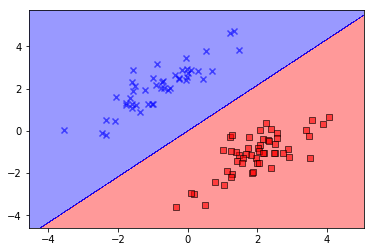

In [14]:
plt.contourf(x1_mesh, x2_mesh, z, alpha=0.4, cmap=cmap)
plt.xlim(x1_mesh.min(), x1_mesh.max())
plt.ylim(x2_mesh.min(), x2_mesh.max())

for idx, cl in enumerate(np.unique(y_test)):
    plt.scatter(x=X_test[y_test == cl, 0],
                y=X_test[y_test == cl, 1],
                alpha=0.6,
                c=cmap(idx),
                edgecolors='black',
                marker=markers[idx],
                label=cl);

# 【問題5】時間の計測
SVMの学習には時間がかかるため、効率的な実装が望まれます。事前学習期間に行なったように、時間を計測して改善していきましょう。特に 
λ
 の更新部分は繰り返し処理が多いため、効率的なコードを目指してください。

雛形

In [15]:
# import time
# t0 = time.time()
# # 何らかの処理
# t1 = time.time()
# print('time : {}s'.format(t1-t0))

### 修正前の学習開始〜予測終了までの実行時間時間

In [16]:
print('修正前の学習開始〜予測終了までの実行時間 : {}s'.format(t1-t0))

修正前の学習開始〜予測終了までの実行時間 : 13.767158031463623s


## <u>結果→分類性能は変わらずに実行時間が<font color="Red">約14秒短縮</font></u>
## 以下より詳細を記載する

### 実行時間の短縮方法
- ラグランジュ乗数の更新を繰り返し、<u>ラグランジュ乗数の平均値の変化量が閾値以下となればラグランジュ乗数の更新を停止する</u>。
- ラグランジュ乗数の更新を停止する閾値については、問題1にて最終的に100以下のサポートベクトルを使用して分類を行なっていた為、今回はその倍の<u>サポートベクトル200個あたりの時のラグランジュ乗数の平均値の差である0.02を使用</u>。

### 修正後のScratchSVMClassifier_r2クラス

In [17]:
class ScratchSVMClassifier_r2():
    
    """
    SVMのスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    lag_th : int
        ラグランジュ乗数の更新を停止する個数(サポートベクトルがこの個数以下となれば、ラグランジュ乗数の更新を停止する)

    Attributes
    ----------
    self.lagrang_ : 次の形のndarray, shape (n_features,)
      ラグランジュ乗数
    self.th : float
      ラグランジュ乗数の更新を続けるかを判断する閾値
    """


    def __init__(self, num_iter, lr, th):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        # 損失を記録する配列を用意
        self.lagrang = None
        self.th = th
        self.X = None
        self.y = None

        
    def fit(self, X, y):
        """
        入力データを読み込み、サポートベクトルを決定する
        Parameters
        ----------
        X : ndarray
            学習データ
        y : ndarray
            学習データ
            
        Returns
        -------
        """
        
        """
        インスタンス変数の初期化 (複数回fitメソッドを実行した際に、過去のインスタンス変数のデータが残らない様にする)
        """
        self.lagrang = None # ラグランジュ乗数の初期化(fitメソッドを実行する為に)
        
        """
        学習データに対しての処理
        """
        # 入力データをnumpy配列に変換
        X = np.array(X)
        y = np.array(y)
        
        # 入力データが１次元か判別
        # １次元の場合→1次元追加し２次元のnumpy配列とする
        if X.ndim == 1:
            X = X[:, np.newaxis]
        
        if y.ndim==1:
            y = y[:, np.newaxis]
            
        self.X = X
        self.y = y

        """    
        ラグランジュ乗数の更新
        """
        self._gradient_descent(X, y)
        
    
    def predict(self, X):

        """
        入力値のデータを求めた分類境界線に代入しラベルを予測する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習データ
            
        Returns
        -------
        prediction_result: int
            予測結果　
        """
        # サポートベクタのインデックスを取得
        index = np.where(self.lagrang > 0)[0]
        
        # 予測
        predict = np.sum(self.lagrang[index] * self.y[index] * self._linear_kernel(X, self.X[index]).T, axis=0)

        # 　値が0より大きい値かで分類する
        predict = np.where(predict > 0, 1, -1)
        
        return predict
    

    def _linear_kernel(self, X_i, X_j):
        
        """
        線型カーネル関数を計算する
        Parameters
        ----------
        X_i : ndarray
            特徴量データ
        X_j : ndarray
            特徴量データ

        Returns
        -------
        次の形のndarray, shape (n_samples, 1)
            カーネル関数の計算結果を格納したnumpy配列
        """
        
        return X_i @ X_j.T

    
    def _gradient_descent(self, X, y):
        """
        ラグランジュ乗数を最適化する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習データ
        y : 次の形のndarray, shape (n_samples, 1)
            
        Returns
        -------
        """
        
        # ラグランジュ乗数を格納するインスタンス変数self.lagrangeのshapeを(n_sample, 1)に変更
        self.lagrang=np.random.rand(len(X)).reshape(-1,1) 
        
        # sum.iter回、繰り返す
        for it in range(self.iter):
            
            # 総和計算の値を格納するリストを初期作成
            sum_list = []
            
            # 入力データのサンプル数繰り返す
            for i in range(len(X)):
                
                # ラグランジュ乗数の変化量を計算しリストに格納
                sum_list.append(np.sum(self.lagrang * y[i] * y * (self._linear_kernel(X, X[i].reshape(1,-1)))))

            # 計算結果をnumpy配列に変換
            sum_np = np.array(sum_list).reshape(-1,1)

            # ラグランジュ乗数を更新
            new_lagrang = self.lagrang + self.lr * (1 - sum_np)
            
            print('現状のラグランジュ乗数の平均値 {}'.format(np.mean(self.lagrang)))
            print('更新後のラグランジュ乗数の平均値{}'.format(np.mean(self.lagrang)))
            print('平均値の差={}'.format((np.mean(self.lagrang) - np.mean(new_lagrang))))
            
            # 現在のラグランジュ乗数の平均値 − 更新後のラグランジュ乗数の平均値　の結果が閾値以下の場合、更新を停止
            if (np.mean(self.lagrang) - np.mean(new_lagrang)) < self.th:
                break
            
            # ラグランジュ乗数を更新
            self.lagrang = new_lagrang
        
            # ラグランジュ乗数の値が指定の値より小さいならばゼロとする
            self.lagrang = np.where(self.lagrang > 1e-5, self.lagrang, 0)
            
            print('ラグランジュ乗数の個数={}'.format(np.count_nonzero(self.lagrang)))
            print('-----------------------------------------------------\n')

### 学習

In [18]:
cls2 = ScratchSVMClassifier_r2(num_iter=3000, lr=0.0001, th=0.02)

### 実行時間の計測

In [19]:
t2 = time.time()
cls2.fit(X_train, y_train)
y_pred2 = cls2.predict(X_test)
t3 = time.time()

現状のラグランジュ乗数の平均値 0.508798129948338
更新後のラグランジュ乗数の平均値0.508798129948338
平均値の差=0.09239274059529728
ラグランジュ乗数の個数=369
-----------------------------------------------------

現状のラグランジュ乗数の平均値 0.42031456748044016
更新後のラグランジュ乗数の平均値0.42031456748044016
平均値の差=0.07557234652096018
ラグランジュ乗数の個数=336
-----------------------------------------------------

現状のラグランジュ乗数の平均値 0.35406300404047714
更新後のラグランジュ乗数の平均値0.35406300404047714
平均値の差=0.06305242988794763
ラグランジュ乗数の個数=316
-----------------------------------------------------

現状のラグランジュ乗数の平均値 0.30354729798596997
更新後のラグランジュ乗数の平均値0.30354729798596997
平均値の差=0.05353659200819327
ラグランジュ乗数の個数=295
-----------------------------------------------------

現状のラグランジュ乗数の平均値 0.2630880963245408
更新後のラグランジュ乗数の平均値0.2630880963245408
平均値の差=0.04592761066789133
ラグランジュ乗数の個数=271
-----------------------------------------------------

現状のラグランジュ乗数の平均値 0.23143767959812003
更新後のラグランジュ乗数の平均値0.23143767959812003
平均値の差=0.040010372000494315
ラグランジュ乗数の個数=256
----------------------------------------------

In [20]:
print(' 修正後の学習開始〜予測終了までの実行時間 : {}s'.format(t2-t3))

 修正後の学習開始〜予測終了までの実行時間 : -0.08719587326049805s


## 実行時間の差分を計算

In [21]:
(t1 - t0) - (t3 - t2)

13.679962158203125

## 予測精度比較

### 修正前

In [22]:
print('accuracy_score = {}\n'.format(accuracy_score(y_test, y_pred1)))

accuracy_score = 1.0



In [23]:
target_names = ['class 1', 'class -1']

In [24]:
print(classification_report(y_test, y_pred1, target_names=target_names))

              precision    recall  f1-score   support

     class 1       1.00      1.00      1.00        53
    class -1       1.00      1.00      1.00        47

   micro avg       1.00      1.00      1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



### 修正後

In [25]:
print('accuracy_score = {}\n'.format(accuracy_score(y_test, y_pred2)))

accuracy_score = 1.0



In [26]:
target_names = ['class 1', 'class -1']

In [27]:
print(classification_report(y_test, y_pred2, target_names=target_names))

              precision    recall  f1-score   support

     class 1       1.00      1.00      1.00        53
    class -1       1.00      1.00      1.00        47

   micro avg       1.00      1.00      1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



# 【問題6】ロジスティック回帰とSVM
最終発表時に以下の内容についてディスカッションを行います。自分なりの意見を用意しておいてください。

ロジスティック回帰とSVMは本質的に何が異なっているか

## ①クラス分類を行う直線の求め方
### ロジスティック回帰
- 各特徴量との誤差の合計が最小となるような直線を引く。

### SVM
- それぞれのクラスのサポートベクトル(クラス分類を行う直線から最も近い特徴量)から最も距離(マージン)が大きくなる直線を引く。

### 上記の違いによる各モデルの特徴
- ロジスティック回帰は全ての特徴量に対して適した直線を引く為、外れ値などにも対応しようとして過学習の可能性が高い。
- SVMは直線を引く為に考慮するのはサポートベクトルのみなので、外れ値の影響を受けない為、ロジスティック回帰と比較し過学習になりにくく、またマージン最大化の観点からより最適な分類を行うことが可能。

## ②計算量の違い
### ロジスティック回帰
- インスタンス変数にて指定された回数分、勾配降下法によるパラメータ最適化を行う。
- 計算回数→指定回数

### SVM
- サポートベクトルを決定する際にインスタンス変数にて指定された回数分、特徴量の２乗の計算を行い、ラグランジュ乗数を勾配降下法により更新し、計算終了時にラグランジュ乗数が0以上であった特徴量をサポートベクトルとする。
- 計算回数→指定回数　×　サンプル数
- 
### 上記の違いによる各モデルの特徴
- ロジスティック回帰は指定された回数分のみ更新を行う為、予測精度をある程度犠牲にした場合は、更新回数を少なくし実行時間を減らすことが可能。
- SVMは指定された回数　×　サンプル数の回数の計算を行う為、ロジスティック回帰と比較し計算量が多くなる。またその傾向は特徴量が多くなるほど顕著となる。その為、大容量のデータに対してはSVMモデルよりロジスティック回帰等の計算量の少ないモデルが適していると想定される。